The alternative explanation is this: when the same digits is paired (10% of the times), DANN is basically just doing supervised training.

## Settings

In [28]:
python_modules_path = python_modules_path = '/Users/adamhuang/Desktop/Summer_Research/network_generalizability/dann_experiments/python_modules'
notebook_name = 'exp-56112.ipynb'
model_name = '56112'

# settings
sv_save_path = '/Users/adamhuang/Desktop/Summer_Research/network_generalizability/dann_experiments/dann/training_csvs/new_training_scheme'
pth_save_path = '/Users/adamhuang/Desktop/Summer_Research/network_generalizability/dann_experiments/dann/trained_models/new_training_scheme'

## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, python_modules_path)
from path_magic import path_magic

import os
path_magic.make_dir_importable_relative(current_fname=os.path.realpath(notebook_name), 
                                        nup=1,
                                        target_dir_name='model_defs',
                                        show=True,
                                        show_with_suffix='py')
path_magic.make_dir_importable_relative(current_fname=os.path.realpath(notebook_name), 
                                        nup=1,
                                        target_dir_name='scripts',
                                        show=True,
                                        show_with_suffix='py')

Message: /Users/yangzhihan/Desktop/projects/domain_transfer/dann/experiments/../model_defs added to sys.path
Contains: ['exp1.py', 'exp3.py']
Message: /Users/yangzhihan/Desktop/projects/domain_transfer/dann/experiments/../scripts added to sys.path
Contains: ['create_mnistm.py', 'utils.py', 'default_path.py', 'load_data.py', 'flip_gradient.py']


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# standard imports for pytorch
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from exp3 import FeatureExtractor, LabelClassifier, Dis  # import model classes
from load_data import load_data_org, edge_detect  # import functions for getting and preprocessing data
from ndarray_info.ndarray_info import get_info

## Define model

In [5]:
feature_extractor = FeatureExtractor()

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)


In [6]:
label_classifier = LabelClassifier()

========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10


In [7]:
def get_models(lr=0.01):
    """Return models and their corresponding optimizers."""
    
    fe = FeatureExtractor().double()
    fe_opt = optim.SGD(fe.parameters(), lr=lr, momentum=0.9)
    
    lc = LabelClassifier().double()
    lc_opt = optim.SGD(lc.parameters(), lr=lr, momentum=0.9)
    
    dis = Dis().double()
    dis_opt = optim.SGD(dis.parameters(), lr=lr, momentum=0.9)
    
    return (fe, fe_opt), (lc, lc_opt), (dis, dis_opt)


## Load data

In [8]:
mnist_path = '../data/MNIST_data'
mnistm_path = '../data/mnistm_data.pkl'

In [9]:
(mnist_train, mnist_train_labels), (mnist_test, mnist_test_labels), (mnistm_train, mnistm_test), (combined_test_imgs, combined_test_labels, combined_test_domain) = load_data_org(mnist_path, mnistm_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
info = get_info(shape=True, dtype=True, mean=True, min=True, max=True)

In [11]:
for array in [mnist_train, 
              mnist_train_labels, 
              mnistm_train,
              mnist_test, 
              mnist_test_labels,
              mnistm_test, 
              combined_test_imgs,
              combined_test_labels, 
              combined_test_domain]:
    info(array)

Array Summary:
* Shape: (55000, 3, 28, 28)
* dtype: float64
* Mean: -0.12921006657207923
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (55000,)
* dtype: int64
* Mean: 4.452745454545455
* Max: 9
* Min: 0
Array Summary:
* Shape: (55000, 3, 28, 28)
* dtype: float64
* Mean: 0.1292100665720834
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (10000, 3, 28, 28)
* dtype: float64
* Mean: -0.1276862377223613
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (10000,)
* dtype: int64
* Mean: 4.4434
* Max: 9
* Min: 0
Array Summary:
* Shape: (10000, 3, 28, 28)
* dtype: float64
* Mean: 0.1308327517067431
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (1000, 3, 28, 28)
* dtype: float64
* Mean: -0.008705471249105723
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (1000,)
* dtype: int64
* Mean: 4.378
* Max: 9
* Min: 0
Array Summary:
* Shape: (1000,)
* dtype: int64
*

## Define training loop function

### Metrics

In [12]:
loss_func = F.cross_entropy

In [13]:
def accuracy(logits : torch.DoubleTensor, truth : torch.LongTensor):
    preds = torch.argmax(logits, dim=1)
    return (preds == truth).float().mean()

### Class for accummulating metric values

In [14]:
class MetricAccumulator:
    
    def __init__(self, nmetric=1):
        self.metrics = [[] for i in range(nmetric)]
        
    def accumulate(self, values):
        for i, value in enumerate(values):
            self.metrics[i].append(value)
            
    def output(self):
        return self.metrics

### Functions for saving metric values as csvs and models as pths

In [15]:
def save_metrics_as_csv(metrics, metric_names, save_path, save_name):
    """
    Save a list of list of metric values (recorded during training) as one csv file.
    
    metrics: a list of list of metric values, e.g. [[1, 2, 3], [7.8, 5.6, 3.4], [50.0, 71.7, 99.9]]
    metric_names: corresponding names of metrics, e.g. ['epoch', 'loss', 'acc']
    param: save_path: e.g. "/Users/username/project_name/training_csvs"
    param: save_name: e.g. "vgg16_training.csv"
    """
    loss_df = pd.DataFrame(np.array(list(zip(*metrics))))
    loss_df.columns = metric_names
    loss_df.to_csv(os.path.join(save_path, save_name))
    print('{} is saved at {}.'.format(save_name, save_path))

In [16]:
def save_model_as_pth(model, save_path, save_name):
    """
    Save weights of a PyTorch model as a pth file.
    
    param: model: e.g. a convolutional neural network
    param: save_path: e.g. "/Users/username/project_name/trained_models"
    param: save_name: e.g. "vgg16.pth"
    """
    torch.save(model.state_dict(), os.path.join(save_path, save_name))
    print('{} is saved at {}.'.format(save_name, save_path))

### Sampling function

In [17]:
def random_sample(data, labels, batch_size, return_type):
    """
    Randomly sample a fixed number of data and labels.
    
    param: data: e.g. images
    param: labels: e.g. image classes
    param: batch_size
    param: return_numpy: whether to return 
        (data_batch, label_batch), (data_tensor, label_tensor) or
        (data_tensor, label_tensor)
    """
    indices = np.random.randint(data.shape[0], size=batch_size)  # generate random indices
    data_batch, label_batch = data[indices], labels[indices]
    data_tensor, label_tensor = torch.from_numpy(data_batch).double(), torch.from_numpy(label_batch).long()
    
    if return_type == 'both':
        return (data_batch, label_batch), (data_tensor, label_tensor)
    elif return_type == 'tensor':
        return (data_tensor, label_tensor)
    elif return_type == 'array':
        return (data_batch, label_batch)

### Function for getting different data with the same label or different labels

In [18]:
def get_data_same_labels(label_batch, all_labels, all_data):
    new_data = []
    for label in label_batch:
        indices_of_same_label = np.where(all_labels == label)[0]
        index_of_same_label = np.random.choice(indices_of_same_label)
        new_data.append(all_data[index_of_same_label])
    new_data = np.array(new_data)
    new_data = torch.from_numpy(new_data)
    return new_data

In [35]:
def get_data_different_labels(label_batch:torch.Tensor, all_labels:np.array, all_data:np.array):
    
    label_batch = label_batch.numpy()
    
    new_data = []
    new_labels = []
    for label in label_batch:
        indices_of_different_label = np.where(all_labels != label)[0]
        index_of_different_label = np.random.choice(indices_of_different_label)
        new_data.append(all_data[index_of_different_label])
        new_labels.append(all_labels[index_of_different_label])
    
    new_data = np.array(new_data)
    new_data = torch.from_numpy(new_data)
    new_labels = np.array(new_labels)
    new_labels = torch.from_numpy(new_labels)
    
    return new_data, new_labels

In [20]:
def get_dataloader(data, labels, bs=64, shuffle=False):
    data, labels = map(torch.from_numpy, [data, labels])
    ds = TensorDataset(data, labels)
    dl = DataLoader(ds, batch_size=bs, shuffle=shuffle)
    return dl

### Dynamic learning rate

In [21]:
def get_p(step, nstep):
    return float(step) / nstep

In [22]:
def get_lrs(step, nstep):
    p = get_p(step, nstep)
    lr = 0.01 / (1. + 10 * p)**0.75
    dis_grad_multiplier = 2. / (1. + np.exp(-10. * p)) - 1
    return (lr, dis_grad_multiplier)

In [23]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Training loop

In [36]:
def train(mode):
    
    if mode == model_name:
    
        nepoch = 10
        steps_per_epoch = 860
        bs = 64
        
        (fe, fe_opt), (lc, lc_opt), (dis, dis_opt) = get_models(lr=0.01)
        accum_train = MetricAccumulator(nmetric=4)  # step, loss, mnist-acc, mnistm-acc
        accum_valid = MetricAccumulator(nmetric=4)
        
        domain_labels = np.concatenate([[0 for i in range(32)], [1 for i in range(32)]])
        domain_labels = torch.LongTensor(domain_labels)

        print('========== Training ========')
        
        for i in range(nepoch):
        
            fe.train(); lc.train()  # training mode
            for j in range(steps_per_epoch):
                
                # update learning rates
#                 lr, fe_grad_multiplier = get_lrs(i*steps_per_epoch+j, nepoch*steps_per_epoch)
                lr, fe_grad_multiplier = 0.01, 0.1

                for param_group in fe_opt.param_groups:
                    param_group['lr'] = lr
                for param_group in lc_opt.param_groups:
                    param_group['lr'] = lr
                for param_group in dis_opt.param_groups:
                    param_group['lr'] = lr
            
                ##### train feature extractor + label classifier

                # feed-forward
                mnist_tensor, mnist_labels = random_sample(mnist_train, mnist_train_labels, int(bs/2), return_type='tensor')
                mnistm_tensor, mnistm_labels = get_data_different_labels(mnist_labels, mnist_train_labels, mnistm_train)
        
                both_data = torch.cat([mnist_tensor, mnistm_tensor])
                
                both_feats = fe(both_data)
                mnist_feats = both_feats[:int(bs/2)]  # only mnist features are passed into label classifier
                mnist_preds = lc(mnist_feats)
                mnist_label_loss = loss_func(mnist_preds, mnist_labels)
                
                # gradient descent and clear gradients
                mnist_label_loss.backward(retain_graph=True)
                fe_opt.step(); fe_opt.zero_grad()  
                lc_opt.step(); lc_opt.zero_grad()
                
                ##### train feature extractor (adversarial) + domain classifier
            
                both_domains = dis(both_feats)
                both_domain_loss = loss_func(both_domains, domain_labels)
                
                # gradient descent and clear gradients
                both_domain_loss.backward()
                dis_opt.step(); dis_opt.zero_grad()
                with torch.no_grad():
                    for p in fe.parameters(): p.grad = (-1) *  p.grad * fe_grad_multiplier
                fe_opt.step(); fe_opt.zero_grad()
                
                # evaluate metrics
                if j % 10 == 0: 
                    
                    # compute metric
                    mnist_label_acc = accuracy(mnist_preds, mnist_labels)
                    mnistm_preds = lc(fe(mnistm_tensor))
                    mnistm_label_acc = accuracy(mnistm_preds, mnistm_labels)
                    both_domain_acc = accuracy(both_domains, domain_labels)
        
                    # accumulate metric values
                    accum_train.accumulate([i * steps_per_epoch + j, 
                                            mnist_label_acc.detach().item(), 
                                            mnistm_label_acc.detach().item(),
                                            both_domain_acc.detach().item()])
                    
                    print('epoch {0:2}/10 {1:3} | mnist-acc {2:6.3f} mnistm-acc {3:6.3f} | domain-acc {4:6.3f} | lr {5:5.5f} l {6:5.5f}'.format(i, j, mnist_label_acc, mnistm_label_acc, both_domain_acc, lr, fe_grad_multiplier))
                    
            ##########
                    
            # TODO: add validation for MNIST-M here
                
            fe.eval(); lc.eval()  # validation mode
                
            mnist_test_dl = get_dataloader(mnist_test, mnist_test_labels)
            mnistm_test_dl = get_dataloader(mnistm_test, mnist_test_labels)

            # feed-forward
            domain_accs = []
            
            mnist_test_accs = []
            for xb, yb in mnist_test_dl:
                feats = fe(xb)
                preds = lc(feats)
                acc = accuracy(preds, yb.long())
                mnist_test_accs.append(acc.detach().item())
                
                domains = dis(feats)
                acc = accuracy(domains, torch.zeros(domains.size(0)).long())
                domain_accs.append(acc.detach().item())
            mnist_test_acc = np.mean(mnist_test_accs)
            
            mnistm_test_accs = []
            for xb, yb in mnistm_test_dl:
                feats = fe(xb)
                preds = lc(feats)
                acc = accuracy(preds, yb.long())
                mnistm_test_accs.append(acc.detach().item())
                
                domains = dis(feats)
                acc = accuracy(domains, torch.ones(domains.size(0)).long())
                domain_accs.append(acc.detach().item())
            mnistm_test_acc = np.mean(mnistm_test_accs)
            
            domain_acc = np.mean(domain_accs)

            # accumulate metric values
            accum_valid.accumulate([(i + 1) * steps_per_epoch, 
                                    mnist_test_acc, 
                                    mnistm_test_acc,
                                    domain_acc])
            
            print('[Validation] mnist acc: {0:5.3f} | mnistm acc: {1:5.3f} | domain acc {2:5.3f}'.format(mnist_test_acc, mnistm_test_acc, domain_acc))
                   
            ##########

        save_metrics_as_csv(accum_train.output(), ['step', 'mnist-acc', 'mnistm-acc', 'domain-acc'], csv_save_path, f'{mode}_train.csv')
        save_metrics_as_csv(accum_valid.output(), ['step', 'mnist-acc', 'mnistm-acc', 'domain-acc'], csv_save_path, f'{mode}_valid.csv')
 
        save_model_as_pth(fe, pth_save_path, f'{mode}_fe.pth')
        save_model_as_pth(lc, pth_save_path, f'{mode}_lc.pth')

In [37]:
train('56112')

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)
========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10
========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 2
========== Training ========
epoch  0/10   0 | mnist-acc  0.125 mnistm-acc  0.000 | domain-acc  0.484 | lr 0.01000 l 0.10000
epoch  0/10  10 | mnist-acc  0.094 mnistm-acc  0.188 | domain-acc  0.500 | lr 0.01000 l 0.10000
epoch  0/10  20 | mnist-acc  0.062 mnistm-acc  0.031 | domain-acc  0.500 | lr 0.01000 l 0.10000
epoch  0/10  30 | mnist-acc  0.094 mni

epoch  0/10 790 | mnist-acc  0.938 mnistm-acc  0.375 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  0/10 800 | mnist-acc  0.969 mnistm-acc  0.531 | domain-acc  0.719 | lr 0.01000 l 0.10000
epoch  0/10 810 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  0/10 820 | mnist-acc  0.969 mnistm-acc  0.500 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  0/10 830 | mnist-acc  1.000 mnistm-acc  0.781 | domain-acc  0.625 | lr 0.01000 l 0.10000
epoch  0/10 840 | mnist-acc  0.906 mnistm-acc  0.406 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  0/10 850 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.734 | lr 0.01000 l 0.10000
[Validation] mnist acc: 0.946 | mnistm acc: 0.524 | domain acc 0.848
epoch  1/10   0 | mnist-acc  0.969 mnistm-acc  0.656 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  1/10  10 | mnist-acc  0.906 mnistm-acc  0.500 | domain-acc  0.625 | lr 0.01000 l 0.10000
epoch  1/10  20 | mnist-acc  0.969 mnistm-acc  0.719 | domain-acc  

epoch  1/10 780 | mnist-acc  0.844 mnistm-acc  0.281 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  1/10 790 | mnist-acc  0.844 mnistm-acc  0.250 | domain-acc  0.938 | lr 0.01000 l 0.10000
epoch  1/10 800 | mnist-acc  0.969 mnistm-acc  0.250 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  1/10 810 | mnist-acc  0.875 mnistm-acc  0.344 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  1/10 820 | mnist-acc  0.844 mnistm-acc  0.125 | domain-acc  1.000 | lr 0.01000 l 0.10000
epoch  1/10 830 | mnist-acc  0.875 mnistm-acc  0.250 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  1/10 840 | mnist-acc  0.875 mnistm-acc  0.312 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  1/10 850 | mnist-acc  0.938 mnistm-acc  0.250 | domain-acc  0.922 | lr 0.01000 l 0.10000
[Validation] mnist acc: 0.904 | mnistm acc: 0.258 | domain acc 0.958
epoch  2/10   0 | mnist-acc  0.875 mnistm-acc  0.188 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  2/10  10 | mnist-acc  0.969 mnistm-acc  0.438 | domain-acc  

epoch  2/10 770 | mnist-acc  1.000 mnistm-acc  0.469 | domain-acc  0.984 | lr 0.01000 l 0.10000
epoch  2/10 780 | mnist-acc  0.906 mnistm-acc  0.531 | domain-acc  0.922 | lr 0.01000 l 0.10000
epoch  2/10 790 | mnist-acc  0.969 mnistm-acc  0.469 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  2/10 800 | mnist-acc  0.906 mnistm-acc  0.312 | domain-acc  1.000 | lr 0.01000 l 0.10000
epoch  2/10 810 | mnist-acc  0.906 mnistm-acc  0.438 | domain-acc  0.984 | lr 0.01000 l 0.10000
epoch  2/10 820 | mnist-acc  0.969 mnistm-acc  0.469 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  2/10 830 | mnist-acc  0.969 mnistm-acc  0.438 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  2/10 840 | mnist-acc  0.875 mnistm-acc  0.438 | domain-acc  0.984 | lr 0.01000 l 0.10000
epoch  2/10 850 | mnist-acc  0.938 mnistm-acc  0.531 | domain-acc  0.953 | lr 0.01000 l 0.10000
[Validation] mnist acc: 0.956 | mnistm acc: 0.437 | domain acc 0.946
epoch  3/10   0 | mnist-acc  1.000 mnistm-acc  0.438 | domain-acc  

epoch  3/10 760 | mnist-acc  0.906 mnistm-acc  0.406 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  3/10 770 | mnist-acc  1.000 mnistm-acc  0.438 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  3/10 780 | mnist-acc  0.938 mnistm-acc  0.375 | domain-acc  1.000 | lr 0.01000 l 0.10000
epoch  3/10 790 | mnist-acc  0.938 mnistm-acc  0.562 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  3/10 800 | mnist-acc  1.000 mnistm-acc  0.438 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  3/10 810 | mnist-acc  0.969 mnistm-acc  0.469 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  3/10 820 | mnist-acc  0.938 mnistm-acc  0.281 | domain-acc  0.984 | lr 0.01000 l 0.10000
epoch  3/10 830 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.969 | lr 0.01000 l 0.10000
epoch  3/10 840 | mnist-acc  0.969 mnistm-acc  0.438 | domain-acc  0.938 | lr 0.01000 l 0.10000
epoch  3/10 850 | mnist-acc  1.000 mnistm-acc  0.562 | domain-acc  0.953 | lr 0.01000 l 0.10000
[Validation] mnist acc: 0.973 | mnistm a

epoch  4/10 750 | mnist-acc  1.000 mnistm-acc  0.375 | domain-acc  0.781 | lr 0.01000 l 0.10000
epoch  4/10 760 | mnist-acc  0.969 mnistm-acc  0.656 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  4/10 770 | mnist-acc  0.875 mnistm-acc  0.656 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  4/10 780 | mnist-acc  0.906 mnistm-acc  0.594 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  4/10 790 | mnist-acc  1.000 mnistm-acc  0.562 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  4/10 800 | mnist-acc  0.938 mnistm-acc  0.594 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  4/10 810 | mnist-acc  1.000 mnistm-acc  0.500 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  4/10 820 | mnist-acc  0.969 mnistm-acc  0.562 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  4/10 830 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  4/10 840 | mnist-acc  0.938 mnistm-acc  0.531 | domain-acc  0.938 | lr 0.01000 l 0.10000
epoch  4/10 850 | mnist-acc  0.938 mnist

epoch  5/10 740 | mnist-acc  0.969 mnistm-acc  0.438 | domain-acc  0.938 | lr 0.01000 l 0.10000
epoch  5/10 750 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  5/10 760 | mnist-acc  0.938 mnistm-acc  0.688 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  5/10 770 | mnist-acc  1.000 mnistm-acc  0.594 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  5/10 780 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  5/10 790 | mnist-acc  0.938 mnistm-acc  0.469 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  5/10 800 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  5/10 810 | mnist-acc  0.969 mnistm-acc  0.531 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  5/10 820 | mnist-acc  1.000 mnistm-acc  0.469 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  5/10 830 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  5/10 840 | mnist-acc  0.969 mnist

epoch  6/10 730 | mnist-acc  0.969 mnistm-acc  0.688 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  6/10 740 | mnist-acc  0.969 mnistm-acc  0.688 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  6/10 750 | mnist-acc  0.969 mnistm-acc  0.781 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  6/10 760 | mnist-acc  0.938 mnistm-acc  0.625 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  6/10 770 | mnist-acc  0.906 mnistm-acc  0.531 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  6/10 780 | mnist-acc  0.969 mnistm-acc  0.594 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  6/10 790 | mnist-acc  0.969 mnistm-acc  0.500 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  6/10 800 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.953 | lr 0.01000 l 0.10000
epoch  6/10 810 | mnist-acc  0.969 mnistm-acc  0.469 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  6/10 820 | mnist-acc  0.969 mnistm-acc  0.656 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  6/10 830 | mnist-acc  0.938 mnist

epoch  7/10 720 | mnist-acc  0.969 mnistm-acc  0.500 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  7/10 730 | mnist-acc  0.969 mnistm-acc  0.656 | domain-acc  0.906 | lr 0.01000 l 0.10000
epoch  7/10 740 | mnist-acc  0.969 mnistm-acc  0.562 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  7/10 750 | mnist-acc  0.938 mnistm-acc  0.594 | domain-acc  0.812 | lr 0.01000 l 0.10000
epoch  7/10 760 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  7/10 770 | mnist-acc  0.938 mnistm-acc  0.438 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  7/10 780 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  7/10 790 | mnist-acc  1.000 mnistm-acc  0.688 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  7/10 800 | mnist-acc  1.000 mnistm-acc  0.750 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  7/10 810 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  7/10 820 | mnist-acc  1.000 mnist

epoch  8/10 710 | mnist-acc  1.000 mnistm-acc  0.781 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  8/10 720 | mnist-acc  0.938 mnistm-acc  0.656 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  8/10 730 | mnist-acc  0.969 mnistm-acc  0.688 | domain-acc  0.797 | lr 0.01000 l 0.10000
epoch  8/10 740 | mnist-acc  0.969 mnistm-acc  0.531 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  8/10 750 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  8/10 760 | mnist-acc  0.969 mnistm-acc  0.562 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  8/10 770 | mnist-acc  1.000 mnistm-acc  0.656 | domain-acc  0.859 | lr 0.01000 l 0.10000
epoch  8/10 780 | mnist-acc  0.938 mnistm-acc  0.500 | domain-acc  0.891 | lr 0.01000 l 0.10000
epoch  8/10 790 | mnist-acc  0.969 mnistm-acc  0.750 | domain-acc  0.781 | lr 0.01000 l 0.10000
epoch  8/10 800 | mnist-acc  0.938 mnistm-acc  0.562 | domain-acc  0.812 | lr 0.01000 l 0.10000
epoch  8/10 810 | mnist-acc  0.938 mnist

epoch  9/10 700 | mnist-acc  0.969 mnistm-acc  0.469 | domain-acc  0.781 | lr 0.01000 l 0.10000
epoch  9/10 710 | mnist-acc  1.000 mnistm-acc  0.531 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  9/10 720 | mnist-acc  1.000 mnistm-acc  0.625 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  9/10 730 | mnist-acc  0.969 mnistm-acc  0.844 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  9/10 740 | mnist-acc  0.969 mnistm-acc  0.688 | domain-acc  0.797 | lr 0.01000 l 0.10000
epoch  9/10 750 | mnist-acc  1.000 mnistm-acc  0.750 | domain-acc  0.781 | lr 0.01000 l 0.10000
epoch  9/10 760 | mnist-acc  1.000 mnistm-acc  0.594 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  9/10 770 | mnist-acc  1.000 mnistm-acc  0.656 | domain-acc  0.875 | lr 0.01000 l 0.10000
epoch  9/10 780 | mnist-acc  1.000 mnistm-acc  0.750 | domain-acc  0.828 | lr 0.01000 l 0.10000
epoch  9/10 790 | mnist-acc  1.000 mnistm-acc  0.688 | domain-acc  0.844 | lr 0.01000 l 0.10000
epoch  9/10 800 | mnist-acc  0.969 mnist

## Inference on MNIST-M

In [38]:
def load_fe(save_path, save_name, device='cpu'):
    model = FeatureExtractor().to(device)
    model.load_state_dict(torch.load(os.path.join(save_path, save_name), map_location=device))
    return model.double()

In [39]:
def load_lc(save_path, save_name, device='cpu'):
    model = LabelClassifier().to(device)
    model.load_state_dict(torch.load(os.path.join(save_path, save_name), map_location=device))
    return model.double()

In [40]:
fe_basic = load_fe(pth_save_path, f'{model_name}_fe.pth')

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)


In [41]:
lc_basic = load_lc(pth_save_path, f'{model_name}_lc.pth')

========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10


In [42]:
def inference(fe, lc, data, labels):
    
    test_ds = TensorDataset(torch.from_numpy(data).double(), torch.from_numpy(labels).long())
    test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)
    # random shuffle & sample => random sample
    
    # feed-forward
    fe.eval(); lc.eval()
    accs = []
    for data, labels in test_dl: 
        feats = fe(data)
        preds = lc(feats)
        acc = accuracy(preds, labels).detach().item()  # compute metric
        accs.append(acc)
    
    return np.mean(accs)

In [43]:
mnist_test_acc = inference(fe_basic, lc_basic, mnist_test, mnist_test_labels)
print('Inference accuracy is {0:4.2f}% on MNIST test.'.format(mnist_test_acc * 100))

Inference accuracy is 96.88% on MNIST test.


In [44]:
mnistm_test_acc = inference(fe_basic, lc_basic, mnistm_test, mnist_test_labels)
print('Inference accuracy is {0:4.2f}% on MNIST-M test.'.format(mnistm_test_acc * 100))

Inference accuracy is 63.67% on MNIST-M test.


## Trend of `fw-loss`

In [45]:
training_csv = pd.read_csv(os.path.join(csv_save_path, f'{model_name}_train.csv'))

In [46]:
training_csv.head()

,Unnamed: 0,step,mnist-acc,mnistm-acc,domain-acc
0,0,0.0,0.12500,0.00000,0.484375
1,1,10.0,0.09375,0.18750,0.500000
2,2,20.0,0.06250,0.03125,0.500000
3,3,30.0,0.09375,0.12500,0.500000
4,4,40.0,0.09375,0.18750,0.656250


In [47]:
def moving_mean(array, lookback=50):
    means = []
    for i in range(len(array) - lookback):
        means.append(np.mean(array[i:i+lookback]))
    return np.array(means)

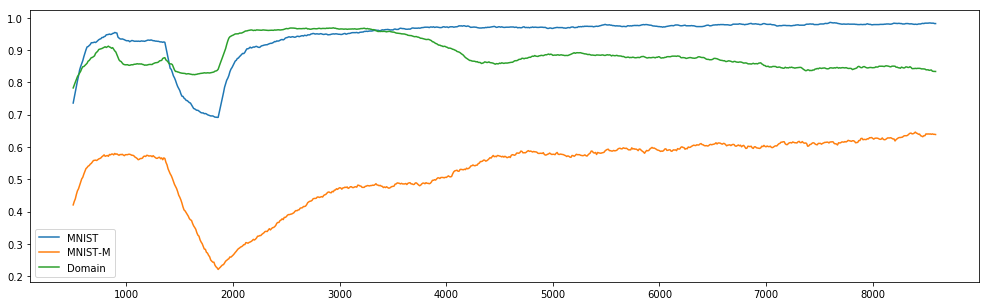

In [48]:
plt.figure(figsize=(17, 5))
steps = np.arange(0, 8600, 10)
plt.plot(steps[50:], moving_mean(training_csv['mnist-acc']), label='MNIST')
plt.plot(steps[50:], moving_mean(training_csv['mnistm-acc']), label='MNIST-M')
plt.plot(steps[50:], moving_mean(training_csv['domain-acc']), label='Domain')
plt.legend()
plt.show()